# Closed-loop replanning with JaxPlan.

This follow-up example provides another way to do closed-loop control in JaxPlan. Starting with the initial state of the system, optimize the action-fluents over a short lookahead horizon (e.g. 5 decision steps), then take the best immediate action from the plan and let the system evolve. Then repeat the process again, taking the best action from the new plan, and so on. This technique is called replanning in the planning literature, which is quite similar in flow to model-predictive control (MPC) where we obtain the dynamics model from the RDDL description.

Start by installing the required packages:

In [1]:
%pip install --quiet --upgrade pip
%pip install --quiet git+https://github.com/pyrddlgym-project/pyRDDLGym.git
%pip install --quiet git+https://github.com/pyrddlgym-project/rddlrepository.git
%pip install --quiet git+https://github.com/pyrddlgym-project/pyRDDLGym-jax.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import the required packages:

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from IPython.display import Image
import os

import pyRDDLGym
from pyRDDLGym.core.visualizer.movie import MovieGenerator
from pyRDDLGym_jax.core.planner import JaxBackpropPlanner, JaxOnlineController, load_config_from_string

We will again optimize the stochastic Wildfire problem from IPPC 2014, noting again the use of the ``vectorized`` option:

In [3]:
env = pyRDDLGym.make('Wildfire_MDP_ippc2014', '1', vectorized=True)

The config file is similar to the open-loop examples, except we also specify the ``rollout_horizon`` parameter to indicate how far ahead we search during optimization:

In [4]:
config = """
[Model]
comparison_kwargs={'weight': 100}
rounding_kwargs={'weight': 100}
control_kwargs={'weight': 100}
[Optimizer]
method='JaxStraightLinePlan'
optimizer_kwargs={'learning_rate': 0.1}
pgpe=None
rollout_horizon=5
[Training]
policy_hyperparams={'cut-out': 5.0, 'put-out': 5.0}
"""
planner_args, _, train_args = load_config_from_string(config)

We now initialize and run our controller. We will **set ``train_seconds`` to 1 to indicate that we want to optimize for 1 second per decision time step**:

In [5]:
planner = JaxBackpropPlanner(rddl=env.model, **planner_args)
agent = JaxOnlineController(planner, print_summary=False, train_seconds=1, **train_args)

[INFO] JAX gradient compiler will cast p-vars {"out-of-fuel'", "burning'", 'put-out', 'out-of-fuel', 'cut-out', 'NEIGHBOR', 'TARGET', 'burning'} to float.
[INFO] JAX gradient compiler will cast CPFs {"out-of-fuel'", "burning'"} to float.
[INFO] Bounds of action-fluent <put-out> set to (None, None).
[INFO] Bounds of action-fluent <cut-out> set to (None, None).
[INFO] SLP will use projected gradient to satisfy max_nondef_actions since total boolean actions 18 > max_nondef_actions 1.


Notice that no optimization is done before calling the ``evaluate`` function, because the replanning method will only optimize when it actually begins interacting with the environment, e.g. it observes the current state, finds the best action, executes it in the environment, then waits for the state to transition and begins again. 

Let's assign a visualizer so we can keep track of the behavior of the planner in real time. Then we just call ``evaluate()`` to actually do the planning:

[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


      0 it /     -368.75790 train /      -71.56250 test /      -71.56250 best / 5 status /      0 pgpe: 100%|██████████| 00:02 , 0.35it/s


[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.

[WARN] JIT compilation dominated the execution time: executing the optimizer again on the traced model [attempt 1].
[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


      1 it /     -110.02679 train /      -73.43750 test /      -71.56250 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 1.23it/s



[WARN] JIT compilation dominated the execution time: executing the optimizer again on the traced model [attempt 2].
[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


    120 it /      -37.81606 train /      -51.78125 test /      -37.32812 best / 0 status /      0 pgpe:  20%|██        | 00:00 , 598.05it/s

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    632 it /      -64.36303 train /      -42.60938 test /      -30.65625 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 632.32it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


     61 it /       -3.89276 train /       -3.57812 test /       -2.48438 best / 0 status /      0 pgpe:  12%|█▏        | 00:00 , 525.68it/s

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    649 it /       -2.51182 train /       -4.17188 test /       -2.37500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 649.87it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    650 it /       -3.25014 train /       -5.50000 test /       -2.37500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 650.36it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    648 it /       -8.70180 train /       -5.00000 test /       -2.37500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 648.42it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    643 it /       -7.44130 train /       -3.87500 test /       -2.37500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 642.94it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


     46 it /       -5.41502 train /       -3.46875 test /       -1.09375 best / 0 status /      0 pgpe:  10%|█         | 00:00 , 467.56it/s

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    648 it /       -1.39169 train /       -5.43750 test /       -1.09375 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 648.91it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    674 it /       -2.74149 train /       -6.76562 test /       -2.37500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 674.85it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    659 it /       -6.07288 train /       -8.21875 test /       -2.37500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 659.65it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    646 it /       -1.63179 train /       -5.45312 test /       -2.37500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 646.88it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    649 it /      -10.64797 train /       -6.09375 test /       -2.37500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 649.68it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    632 it /       -1.81651 train /       -4.70312 test /       -2.37500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 632.61it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    648 it /       -8.33386 train /       -6.48438 test /       -2.37500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 648.74it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    633 it /       -2.49504 train /       -3.67188 test /       -2.37500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 633.64it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    608 it /       -5.69605 train /       -4.68750 test /       -1.71875 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 608.97it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    609 it /      -12.14654 train /       -5.62500 test /       -2.37500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 609.15it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    621 it /       -3.34138 train /       -5.00000 test /       -2.37500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 620.50it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    625 it /       -2.86825 train /       -4.81250 test /       -2.37500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 625.13it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    617 it /       -3.18405 train /       -3.82812 test /       -2.37500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 617.95it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    571 it /       -2.95379 train /       -5.62500 test /       -2.37500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 571.84it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    622 it /       -2.86825 train /       -4.81250 test /       -2.18750 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 622.21it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    660 it /       -2.74149 train /       -6.76562 test /       -2.37500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 660.58it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    671 it /       -8.50487 train /       -4.60938 test /       -1.56250 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 671.68it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    655 it /       -3.38371 train /       -6.73438 test /       -2.37500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 655.76it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    649 it /       -4.38495 train /       -4.78125 test /       -2.37500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 649.31it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    603 it /       -4.25764 train /       -4.48438 test /       -2.37500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 602.79it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    647 it /       -4.38495 train /       -4.78125 test /       -2.37500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 647.14it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    639 it /       -4.90418 train /       -8.07812 test /       -2.37500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 639.03it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    545 it /      -57.62524 train /      -45.85938 test /      -34.35938 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 545.40it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    575 it /       -1.92836 train /       -7.21875 test /       -0.78125 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 575.93it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    639 it /       -2.36973 train /       -6.15625 test /       -1.75000 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 638.89it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    641 it /       -4.57663 train /       -5.60938 test /       -0.93750 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 641.38it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    642 it /       -7.06316 train /       -6.65625 test /       -1.43229 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 642.55it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    657 it /       -1.76880 train /       -3.31250 test /       -0.78125 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 656.66it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    659 it /      -49.18130 train /      -31.28125 test /      -20.01562 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 659.17it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    637 it /      -81.41990 train /      -47.60938 test /      -27.62500 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 637.90it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


     56 it /       -1.48421 train /       -2.48438 test /       -0.00000 best / 0 status /      0 pgpe:  10%|█         | 00:00 , 562.68it/s

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    661 it /       -1.61248 train /       -1.10938 test /       -0.00000 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 661.84it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    606 it /       -0.85516 train /       -2.40625 test /       -0.00000 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 606.89it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    664 it /       -1.05586 train /       -2.12500 test /       -0.64062 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 664.08it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    645 it /       -9.32504 train /       -3.68750 test /       -0.15625 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 644.62it/s



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    670 it /       -0.43191 train /       -2.54688 test /       -0.64062 best / 5 status /      0 pgpe: 100%|██████████| 00:01 , 670.83it/s


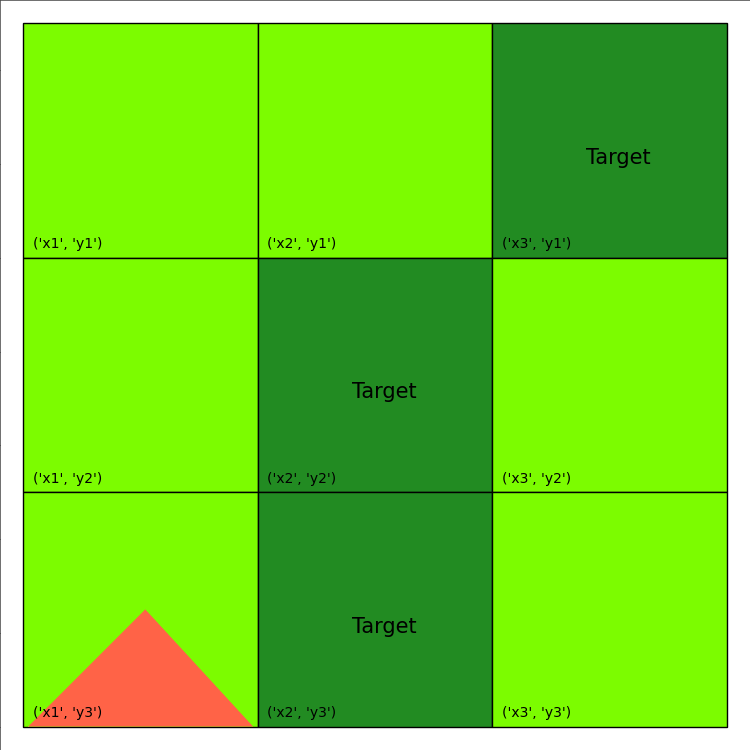

In [6]:
if not os.path.exists('frames'):
    os.makedirs('frames')
recorder = MovieGenerator("frames", "wildfire", max_frames=env.horizon)
env.set_visualizer(viz=None, movie_gen=recorder)

agent.evaluate(env, episodes=1, render=True)
env.close()
Image(filename='frames/wildfire_0.gif') 